In [1]:
# Required libraries are imported
import numpy as np
import pandas as pd
import math
from mpmath import mp
import matplotlib.pyplot as plt
import os
import struct
import numpy as np
import time
from IPython.display import display_html

In [2]:
# Function which allows to randomly shuffle data
def shuffle_data(X, y):
    combined = list(zip(X, y))
    np.random.shuffle(combined)
    X[:], y[:] = zip(*combined)

In [3]:
# Load train data set
X_train_all = pd.read_csv('train/X_train.txt', delim_whitespace=True, header=None).to_numpy()
y_train_all = pd.read_csv('train/y_train.txt', delim_whitespace=True, header=None).to_numpy()

In [4]:
# Performing stratified split of data into training and validation sets
X_valid = np.empty((0, X_train_all.shape[1]))
X_train = np.empty((0, X_train_all.shape[1]))
y_valid = np.empty((0, y_train_all.shape[1]))
y_train = np.empty((0, y_train_all.shape[1]))

# Splitting in loop for every label
for label in np.unique(y_train_all):
    # Find indices where the label matches
    label_indices = np.where(y_train_all == label)[0]
    
    # Randomly choose 10% of these indices for validation
    valid_indices = np.random.choice(label_indices, int(round(0.1 * len(label_indices))), replace=False)
    train_indices = np.setdiff1d(label_indices, valid_indices)

    # Append the corresponding data to X_valid, X_train, y_valid, y_train
    X_valid = np.concatenate([X_valid, X_train_all[valid_indices]])
    X_train = np.concatenate([X_train, X_train_all[train_indices]])
    y_valid = np.concatenate([y_valid, y_train_all[valid_indices]])
    y_train = np.concatenate([y_train, y_train_all[train_indices]])

In [5]:
# Load test data set
X_test = pd.read_csv('test/X_test.txt', delim_whitespace=True, header=None).to_numpy()
y_test = pd.read_csv('test/y_test.txt', delim_whitespace=True, header=None).to_numpy()

# One-hot encode the y_test, y_train, and y_valid labels for 6 classes
y_test = np.eye(6)[y_test.astype(int).reshape(-1)-1]
y_train = np.eye(6)[y_train.astype(int).reshape(-1)-1]
y_valid = np.eye(6)[y_valid.astype(int).reshape(-1)-1]

In [6]:
shuffle_data(X_train, y_train)

In [7]:
def RELU(x): # RELU function
    return np.where(x > 0, x, 0)

In [8]:
def derivative_RELU(x): # The derivative of the Rectified Linear Unit (ReLU) activation function with respect to the input x
    return np.where(x > 0, 1, 0)

In [9]:
def softmax(x):
    # Shift the input 'x' by subtracting the max value in each row to improve numerical stability
    shifted_x = x - x.max(axis=1, keepdims=True)
    # Calculate softmax: exponentiate shifted 'x', and normalize by the sum across the rows
    return np.exp(shifted_x)/np.sum(np.exp(shifted_x), axis=1, keepdims=True)

In [72]:
def missclassfied_patterns(model, X, y):
    # Identify and count misclassified patterns by comparing predictions with actual labels.
    all_patterns = pd.DataFrame([[np.argmax(row1), np.argmax(row2)] for row1, row2 in zip(model.one_hot(model.forward(X)), y)], columns=['y_pred', 'y_true'])
    return all_patterns[all_patterns['y_pred'] != all_patterns['y_true']].value_counts().reset_index()

In [84]:
def display(dfs, titles=[]):
    html_str = ''
    # Iterate over each DataFrame and its corresponding title
    for df, title in zip(dfs, titles):
        # Construct HTML table headers and add title if provided
        html_str += f'<th style="text-align:center"><td style="vertical-align:top">'
        html_str += f'<h2>{title}</h2>'
        # Convert the DataFrame to HTML and adjust the table style for inline display
        html_str += df.to_html().replace('table','table style="display:inline"')
        html_str += '</td></th>'
        
     # Display the HTML content in the Jupyter Notebook
    display_html(html_str, raw=True)

In [119]:
class NeuralNetwork:
    # Constructor: initializes the neural network with given parameters
    def __init__(self, input_neurons, h1_neurons, h2_neurons, output_neurons, learning_rate):
        # Initialize network parameters: neurons in each layer and learning rate
        self.input_neurons = input_neurons
        self.h1_neurons = h1_neurons
        self.h2_neurons = h2_neurons
        self.output_neurons = output_neurons
        self.learning_rate = learning_rate
        
        # Initialize momentum variables for weights and biases (used in training updates)
        self.momentum_weights1 = 0
        self.momentum_bias1 = 0
        self.momentum_weights2 = 0
        self.momentum_bias2 = 0
        self.momentum_weights3 = 0
        self.momentum_bias3 = 0
        self.initialize_weights()  # Initialize weights and biases

    # Initialize weights and biases with small random values
    def initialize_weights(self):
        # Initialize the weights for the first layer.
        self.weights1 = np.random.uniform(-0.1, 0.1, size=(self.h1_neurons, self.input_neurons))
        self.bias1 = np.random.uniform(-0.1, 0.1, size=(self.h1_neurons))
        
        # Initialize the weights for the second layer.
        self.weights2 = np.random.uniform(-0.1, 0.1, size=(self.h2_neurons, self.h1_neurons))
        self.bias2 = np.random.uniform(-0.1, 0.1, size=(self.h2_neurons))
        
        #Initialize the weights for the output layer.
        self.weights3 = np.random.uniform(-0.1, 0.1, size=(self.output_neurons, self.h2_neurons))
        self.bias3 = np.random.uniform(-0.1, 0.1, size=(self.output_neurons))

    # Forward pass: computes the output of the network for a given input X
    def forward(self, X, dropped_neurons=np.empty(0), dropout_rate=0):
        # First hidden layer: Apply linear transformation and ReLU activation
        self.v1 = np.dot(X, self.weights1.T) + self.bias1
        self.h1 = RELU(self.v1)  # ReLU activation
        
        # Second hidden layer: Apply linear transformation
        self.v2 = np.dot(self.h1, self.weights2.T) + self.bias2
        
        if dropout_rate == 0: #If dropout_rate is equal to zero do not aplly dropout
            self.h2 = RELU(self.v2)
        else: #If dropout_rate is not equal to zero aplly dropout
            self.v2[:, dropped_neurons] = 0 # Dropout
            self.h2 = (1/(1 - dropout_rate)) * RELU(self.v2)  # ReLU activation with compensation for dropout

         # Output layer: Apply linear transformation and softmax activation
        self.v3 = np.dot(self.h2, self.weights3.T) + self.bias3
        self.y = softmax(self.v3)
        
        return self.y
    
    # Backward pass: computes gradients and updates weights and biases
    def backward(self, X, y, alpha_momentum, dropped_neurons, dropout_rate):
        # Perform forward pass to get the network's output
        forward_output = self.forward(X, dropped_neurons, dropout_rate)
        
        # Compute gradient of error with respect to output layer
        self.dE_dv3 = forward_output - y
        
        # Compute gradients of error with respect to weights and biases of the output layer
        self.dE_dw3 = np.dot(self.dE_dv3.T, self.h2)
        self.dE_db3 = np.sum(self.dE_dv3, axis=0)
        
        # Compute gradients for second hidden layer
        self.dE_dh2 = np.dot(self.dE_dv3, self.weights3)
        self.dE_dw2 = np.dot((self.dE_dh2 * derivative_RELU(self.v2)).T, self.h1)
        self.dE_db2 = np.sum(self.dE_dh2 * derivative_RELU(self.v2), axis=0)
        
        # Compute gradients for first hidden layer
        self.dE_dh1 = np.dot(self.dE_dh2 * derivative_RELU(self.v2), self.weights2)
        self.dE_dw1 = np.dot((self.dE_dh1 * derivative_RELU(self.v1)).T, X)
        self.dE_db1 = np.sum(self.dE_dh1 * derivative_RELU(self.v1), axis=0)
        
        # Update weights and biases using the calculated gradients and momentum
        # Momentum is used to accelerate gradients vectors in the right directions, thus leading to faster converging
        self.weights1 -= self.learning_rate * self.dE_dw1 + alpha_momentum * self.momentum_weights1
        self.bias1 -= self.learning_rate * self.dE_db1 + alpha_momentum * self.momentum_bias1
        self.weights2 -= self.learning_rate * self.dE_dw2 + alpha_momentum * self.momentum_weights2
        self.bias2 -= self.learning_rate * self.dE_db2 + alpha_momentum * self.momentum_bias2
        self.weights3 -= self.learning_rate * self.dE_dw3 + alpha_momentum * self.momentum_weights3
        self.bias3 -= self.learning_rate * self.dE_db3 + alpha_momentum * self.momentum_bias3
        
        # Update momentum terms
        self.momentum_weights1 = self.learning_rate * self.dE_dw1
        self.momentum_bias1 = self.learning_rate * self.dE_db1
        self.momentum_weights2 = self.learning_rate * self.dE_dw2
        self.momentum_bias2 = self.learning_rate * self.dE_db2
        self.momentum_weights3 = self.learning_rate * self.dE_dw3
        self.momentum_bias3 = self.learning_rate * self.dE_db3
        
    # Backward pass with batch processing
    def backward_with_batch_size(self, X, y, batch_size, alpha_momentum, dropout_rate):
        batches = -(-X.shape[0] // batch_size)  # Calculate number of batches
        for batch in range(batches):
            # Select a subset of neurons for dropout, if dropout is applied
            all_neurons = np.arange(0, self.h2_neurons)
            dropped_neurons = np.random.choice(all_neurons, int(dropout_rate * self.h2_neurons), replace=False)
            
            # Determine the start and end indices for the current batch
            start = batch * batch_size
            end = min(start + batch_size, X.shape[0])
            
            # Perform the backward pass for the current batch
            self.backward(X[start:end], y[start:end], alpha_momentum, dropped_neurons, dropout_rate)
   
    # Train the neural network     
    def train_early_stopping(self, X, y, X_valid, y_valid, batch_size=1, patiance_limit=100, alpha_momentum=0, dropout_rate=0):
        self.start_time = time.time() # Start time for training
        
        # Initialize lists to store weights and biases for analysis
        self.weights1_list = []
        self.weights2_list = []
        self.weights3_list = []
        self.bias1_list = []
        self.bias2_list = []
        self.bias3_list = []
        
        # Append set of parameters before training starts
        self.weights1_list.append(np.copy(self.weights1))
        self.weights2_list.append(np.copy(self.weights2))
        self.weights3_list.append(np.copy(self.weights3))
        self.bias1_list.append(np.copy(self.bias1))
        self.bias2_list.append(np.copy(self.bias2))
        self.bias3_list.append(np.copy(self.bias3))
        
        # Calculate the initial accuracy on the validation set to determine the best model.
        best_val_accuracy = self.calculate_accuracy(X_valid, y_valid)
        
        # Initialize the patience factor to monitor validation accuracy improvement.
        patiance_factor = 0
        
        # Counter for the number of epochs processed.
        counted_epochs = 0
        
        # Iterate over epochs until the patience limit is reached.
        while patiance_factor < patiance_limit:
            
            # Train using specific batch size
            self.backward_with_batch_size(X, y, batch_size, alpha_momentum, dropout_rate)
            
            # Calculate the current accuracy on the validation set.
            current_val_accuracy = self.calculate_accuracy(X_valid, y_valid)
            
            # Update best validation accuracy and reset patience if there is an improvement.
            if current_val_accuracy > best_val_accuracy:
                best_val_accuracy = current_val_accuracy
                patiance_factor = 0
            else:
                # Increment patience factor if no improvement in validation accuracy.
                patiance_factor += 1
            
            # Store the current weights and biases after each epoch.
            self.weights1_list.append(np.copy(self.weights1))
            self.weights2_list.append(np.copy(self.weights2))
            self.weights3_list.append(np.copy(self.weights3))
            self.bias1_list.append(np.copy(self.bias1))
            self.bias2_list.append(np.copy(self.bias2))
            self.bias3_list.append(np.copy(self.bias3))
            counted_epochs += 1 # Increment the epoch counter.
            
        # Set the total number of epochs completed.
        self.epochs = counted_epochs
        self.end_time = time.time() # End time for training
        
    def post_training_evaluation(self, X_train, y_train, X_valid, y_valid, X_test, y_test):
        # Retrieve the number of epochs from the training phase.
        epochs = self.epochs
        
        # Initialize arrays to store training, valitation, testing error and accuracy metrics for each epoch.
        self.train_error_list = np.zeros(epochs+1)
        self.valid_error_list = np.zeros(epochs+1)
        self.test_error_list = np.zeros(epochs+1)
        self.train_accuracy_list = np.zeros(epochs+1)
        self.valid_accuracy_list = np.zeros(epochs+1)
        self.test_accuracy_list = np.zeros(epochs+1)
        
        # Loop over each epoch to evaluate the model's performance with the corresponding weights and biases.
        for epoch in range(epochs+1):
            # Load the weights and biases from each epoch.
            self.weights1 = np.copy(self.weights1_list[epoch])
            self.weights2 = np.copy(self.weights2_list[epoch])
            self.weights3 = np.copy(self.weights3_list[epoch])
            self.bias1 = np.copy(self.bias1_list[epoch])
            self.bias2 = np.copy(self.bias2_list[epoch])
            self.bias3 = np.copy(self.bias3_list[epoch])
            
            # Compute and store the training, validation and testing error for the current epoch.
            self.train_error_list[epoch] = self.score(X_train, y_train)
            self.valid_error_list[epoch] = self.score(X_valid, y_valid)
            self.test_error_list[epoch] = self.score(X_test, y_test)
            
            # Compute and store training, validation and testing accuracies for the current epoch.
            self.train_accuracy_list[epoch] = self.calculate_accuracy(X_train, y_train)
            self.valid_accuracy_list[epoch] = self.calculate_accuracy(X_valid, y_valid)
            self.test_accuracy_list[epoch] = self.calculate_accuracy(X_test, y_test)
            
        # Identify the epoch with the best validation accuracy.
        best_model = np.argmax(self.valid_accuracy_list)
        
        # Load weights and biases of the best model.
        self.weights1 = np.copy(self.weights1_list[best_model])
        self.weights2 = np.copy(self.weights2_list[best_model])
        self.weights3 = np.copy(self.weights3_list[best_model])            
        self.bias1 = np.copy(self.bias1_list[best_model])
        self.bias2 = np.copy(self.bias2_list[best_model])
        self.bias3 = np.copy(self.bias3_list[best_model])
        
        # Calculate the total training time in minutes
        cpu_time = (self.end_time - self.start_time)/60
        
        # Compile a dictionary of statistics for performance evaluation.
        statistics = {
            'epochs': self.epochs,
            'cpu_time': cpu_time,
            'best_model_train_error': self.train_error_list[best_model],
            'best_model_valid_error': self.valid_error_list[best_model],
            'best_model_test_error': self.test_error_list[best_model],
            'best_model_train_accuracy': self.train_accuracy_list[best_model],
            'best_model_valid_accuracy': self.valid_accuracy_list[best_model],
            'best_model_test_accuracy': self.test_accuracy_list[best_model]
        }
        return statistics
    
    def score(self, X, y):
        # Predict output for X and compute the cross-entropy loss
        y_pred = self.forward(X)
        y_pred_clipped = np.clip(y_pred, 1e-12, 1. - 1e-12)
        cross_entropy = -np.sum(y * np.log(y_pred_clipped), axis=1)
        return np.mean(cross_entropy)
        
    def one_hot(self, results):
        # Convert a batch of vectors (results) to a one-hot encoded matrix
        one_hot_encoded = np.zeros_like(results)
        one_hot_encoded[np.arange(len(results)), np.argmax(results, axis=1)] = 1
        return one_hot_encoded
    
    def calculate_accuracy(self, X, y):
        # Calculate accuracy as the proportion of correct predictions
        predictions = self.one_hot(self.forward(X))
        correct_predictions = np.sum(np.all(predictions == y, axis=1))
        accuracy = correct_predictions / len(y)
        return accuracy
    
    # Plotting metrics for analysis
    def plots(self):
        # Create a figure with two subplots for accuracy and error metrics
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        
        # Plot accuracy for training, validation, and test sets on the first subplot
        ax1.plot(self.train_accuracy_list, label='train_accuracy')
        ax1.plot(self.valid_accuracy_list, label='valid_accuracy')
        ax1.plot(self.test_accuracy_list, label='test_accuracy')
        ax1.legend()
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('accuracy')
        
         # Plot error (loss) for training, validation, and test sets on the second subplot
        ax2.plot(self.train_error_list, label='train_error')
        ax2.plot(self.valid_error_list, label='valid_error')
        ax2.plot(self.test_error_list, label='test_error')
        ax2.legend()
        ax2.set_xlabel('epochs')
        ax2.set_ylabel('loss')

        # Display the plots
        plt.show()

# 1 model with learning_rate=0.001, h1_neurons=300, h2_neurons=100, alpha_momentum=0, batch_size=1(online learning)

In [11]:
m1 = NeuralNetwork(input_neurons=X_train.shape[1], h1_neurons=300, h2_neurons=100, output_neurons=6, learning_rate=0.001)
m1.train_early_stopping(X_train, y_train, X_valid, y_valid, batch_size=1, alpha_momentum=0)
m1_stats = m1.post_training_evaluation(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [85]:
display([missclassfied_patterns(m1, X_train, y_train), missclassfied_patterns(m1, X_valid, y_valid), missclassfied_patterns(m1, X_test, y_test)], ['missclassfied_train', 'missclassfied_valid', 'missclassfied_test'])

,y_pred,y_true,0
,y_pred,y_true,0
0,3,4,6
1,4,3,4
2,2,0,2
3,0,1,1
4,1,0,1
,y_pred,y_true,0
0,4,3,48
1,0,1,21
2,1,2,19


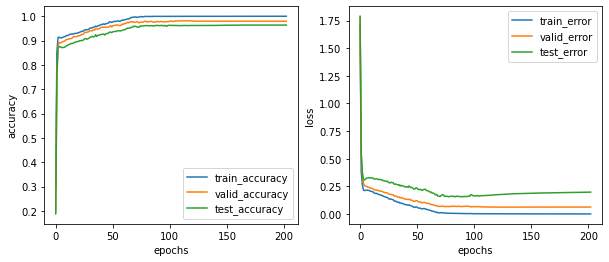

In [103]:
m1.plots()

# 2 model with learning_rate=0.01, h1_neurons=300, h2_neurons=100, alpha_momentum=0, batch_size=1(online learning)

In [12]:
m2 = NeuralNetwork(input_neurons=X_train.shape[1], h1_neurons=300, h2_neurons=100, output_neurons=6, learning_rate=0.01)
m2.train_early_stopping(X_train, y_train, X_valid, y_valid, batch_size=1, alpha_momentum=0)
m2_stats = m2.post_training_evaluation(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [86]:
display([missclassfied_patterns(m2, X_train, y_train), missclassfied_patterns(m2, X_valid, y_valid), missclassfied_patterns(m2, X_test, y_test)], ['missclassfied_train', 'missclassfied_valid', 'missclassfied_test'])

,y_pred,y_true,0
0,4,3,27
1,3,4,16
,y_pred,y_true,0
0,4,3,6
1,2,0,2
2,0,1,1
3,1,0,1
4,3,4,1
,y_pred,y_true,0
0,4,3,56


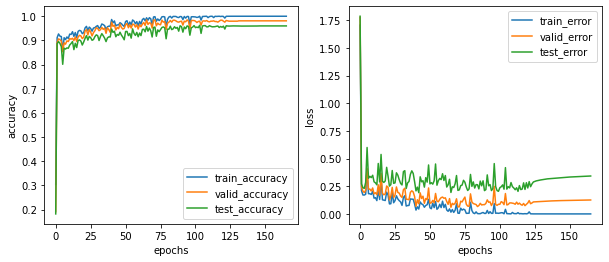

In [104]:
m2.plots()

# 3 model with learning_rate=0.001, h1_neurons=300, h2_neurons=200, alpha_momentum=0, batch_size=1(online learning)

In [13]:
m3 = NeuralNetwork(input_neurons=X_train.shape[1], h1_neurons=300, h2_neurons=200, output_neurons=6, learning_rate=0.001)
m3.train_early_stopping(X_train, y_train, X_valid, y_valid, batch_size=1, alpha_momentum=0)
m3_stats = m3.post_training_evaluation(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [87]:
display([missclassfied_patterns(m3, X_train, y_train), missclassfied_patterns(m3, X_valid, y_valid), missclassfied_patterns(m3, X_test, y_test)], ['missclassfied_train', 'missclassfied_valid', 'missclassfied_test'])

,y_pred,y_true,0
,y_pred,y_true,0
0,4,3,6
1,3,4,5
2,1,0,1
3,1,2,1
4,2,0,1
,y_pred,y_true,0
0,4,3,57
1,0,1,22
2,1,2,20


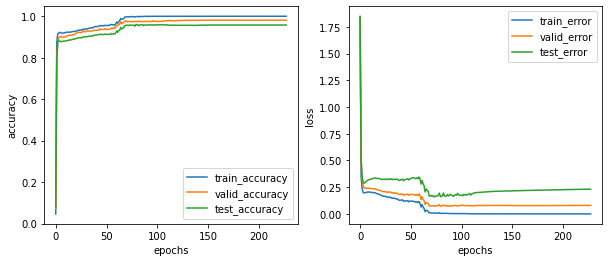

In [105]:
m3.plots()

# 4 model with learning_rate=0.01, h1_neurons=300, h2_neurons=200, alpha_momentum=0, batch_size=1(online learning)

In [14]:
m4 = NeuralNetwork(input_neurons=X_train.shape[1], h1_neurons=300, h2_neurons=200, output_neurons=6, learning_rate=0.01)
m4.train_early_stopping(X_train, y_train, X_valid, y_valid, batch_size=1, alpha_momentum=0)
m4_stats = m4.post_training_evaluation(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [88]:
display([missclassfied_patterns(m4, X_train, y_train), missclassfied_patterns(m4, X_valid, y_valid), missclassfied_patterns(m4, X_test, y_test)], ['missclassfied_train', 'missclassfied_valid', 'missclassfied_test'])

,y_pred,y_true,0
0,4,3,22
1,3,4,5
,y_pred,y_true,0
0,4,3,6
1,2,0,2
2,3,4,2
3,0,1,1
4,1,0,1
,y_pred,y_true,0
0,4,3,69


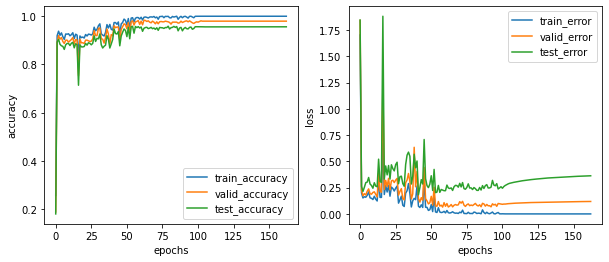

In [106]:
m4.plots()

# 5 model with learning_rate=0.001, h1_neurons=300, h2_neurons=100, alpha_momentum=0, batch_size=50

In [15]:
m5 = NeuralNetwork(input_neurons=X_train.shape[1], h1_neurons=300, h2_neurons=100, output_neurons=6, learning_rate=0.001)
m5.train_early_stopping(X_train, y_train, X_valid, y_valid, batch_size=50, alpha_momentum=0)
m5_stats = m5.post_training_evaluation(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [89]:
display([missclassfied_patterns(m5, X_train, y_train), missclassfied_patterns(m5, X_valid, y_valid), missclassfied_patterns(m5, X_test, y_test)], ['missclassfied_train', 'missclassfied_valid', 'missclassfied_test'])

,y_pred,y_true,0
0,3,4,15
1,4,3,3
,y_pred,y_true,0
0,4,3,4
1,2,0,3
2,1,2,2
3,0,1,1
4,3,4,1
,y_pred,y_true,0
0,4,3,45


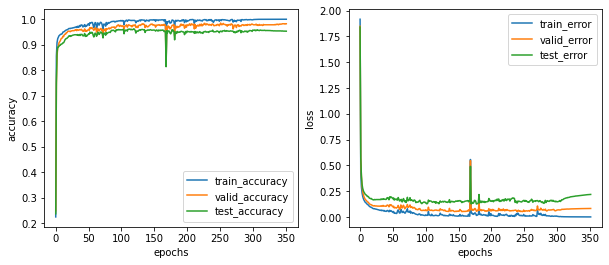

In [107]:
m5.plots()

# 6 model with learning_rate=0.01, h1_neurons=300, h2_neurons=100, alpha_momentum=0, batch_size=50

In [16]:
m6 = NeuralNetwork(input_neurons=X_train.shape[1], h1_neurons=300, h2_neurons=100, output_neurons=6, learning_rate=0.01)
m6.train_early_stopping(X_train, y_train, X_valid, y_valid, batch_size=50, alpha_momentum=0)
m6_stats = m6.post_training_evaluation(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [90]:
display([missclassfied_patterns(m6, X_train, y_train), missclassfied_patterns(m6, X_valid, y_valid), missclassfied_patterns(m6, X_test, y_test)], ['missclassfied_train', 'missclassfied_valid', 'missclassfied_test'])

,y_pred,y_true,0
0,5,4,1699
1,5,3,1261
2,1,0,244
3,1,2,120
4,2,1,65
5,2,0,61
6,4,1,5
7,4,5,4
8,4,0,3
9,5,1,2


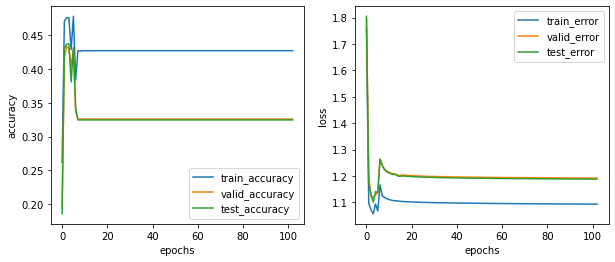

In [108]:
m6.plots()

# 7 model with learning_rate=0.001, h1_neurons=300, h2_neurons=200, alpha_momentum=0, batch_size=50

In [17]:
m7 = NeuralNetwork(input_neurons=X_train.shape[1], h1_neurons=300, h2_neurons=200, output_neurons=6, learning_rate=0.001)
m7.train_early_stopping(X_train, y_train, X_valid, y_valid, batch_size=50, alpha_momentum=0)
m7_stats = m7.post_training_evaluation(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [91]:
display([missclassfied_patterns(m7, X_train, y_train), missclassfied_patterns(m7, X_valid, y_valid), missclassfied_patterns(m7, X_test, y_test)], ['missclassfied_train', 'missclassfied_valid', 'missclassfied_test'])

,y_pred,y_true,0
0,4,3,14
1,3,4,11
,y_pred,y_true,0
0,4,3,4
1,2,0,2
2,3,4,2
3,1,0,1
,y_pred,y_true,0
0,4,3,48
1,0,1,26


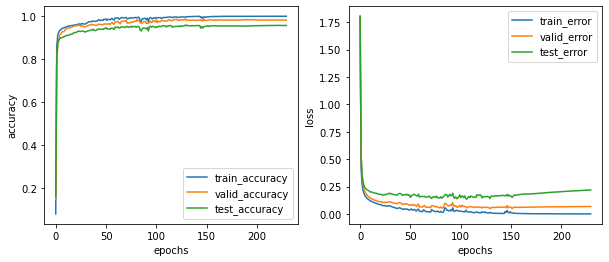

In [109]:
m7.plots()

# 8 model with learning_rate=0.01, h1_neurons=300, h2_neurons=200, alpha_momentum=0, batch_size=50

In [18]:
m8 = NeuralNetwork(input_neurons=X_train.shape[1], h1_neurons=300, h2_neurons=200, output_neurons=6, learning_rate=0.01)
m8.train_early_stopping(X_train, y_train, X_valid, y_valid, batch_size=50, alpha_momentum=0)
m8_stats = m8.post_training_evaluation(X_train, y_train, X_valid, y_valid, X_test, y_test)

C:\Program Files\KMSpico\temp\ipykernel_15636\12394872.py:2: RuntimeWarning: invalid value encountered in subtract
  shifted_x = x - x.max(axis=1, keepdims=True)


In [92]:
display([missclassfied_patterns(m8, X_train, y_train), missclassfied_patterns(m8, X_valid, y_valid), missclassfied_patterns(m8, X_test, y_test)], ['missclassfied_train', 'missclassfied_valid', 'missclassfied_test'])

,y_pred,y_true,0
0,0,5,2026
1,0,4,1699
2,0,3,1261
3,0,2,802
4,0,1,520
,y_pred,y_true,0
0,0,5,141
1,0,4,137
2,0,3,129
3,0,1,107


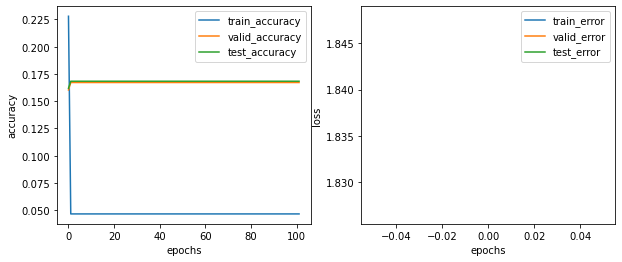

In [110]:
m8.plots()

# 9 model with learning_rate=0.001, h1_neurons=300, h2_neurons=100, alpha_momentum=0.9, batch_size=1(online learning)

In [19]:
m9 = NeuralNetwork(input_neurons=X_train.shape[1], h1_neurons=300, h2_neurons=100, output_neurons=6, learning_rate=0.001)
m9.train_early_stopping(X_train, y_train, X_valid, y_valid, batch_size=1, alpha_momentum=0.9)
m9_stats = m9.post_training_evaluation(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [93]:
display([missclassfied_patterns(m9, X_train, y_train), missclassfied_patterns(m9, X_valid, y_valid), missclassfied_patterns(m9, X_test, y_test)], ['missclassfied_train', 'missclassfied_valid', 'missclassfied_test'])

,y_pred,y_true,0
0,4,3,14
1,3,4,1
,y_pred,y_true,0
0,4,3,6
1,2,0,2
2,3,4,2
3,1,0,1
4,1,2,1
5,5,3,1
,y_pred,y_true,0


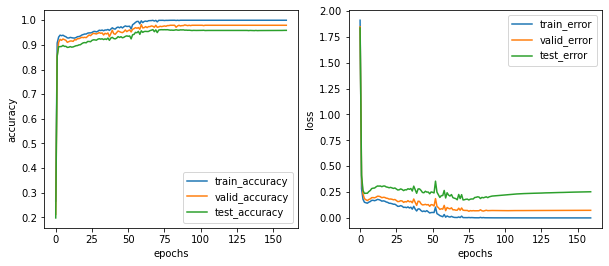

In [111]:
m9.plots()

# 10 model with learning_rate=0.01, h1_neurons=300, h2_neurons=100, alpha_momentum=0.9, batch_size=1(online learning)

In [20]:
m10 = NeuralNetwork(input_neurons=X_train.shape[1], h1_neurons=300, h2_neurons=100, output_neurons=6, learning_rate=0.01)
m10.train_early_stopping(X_train, y_train, X_valid, y_valid, batch_size=1, alpha_momentum=0.9)
m10_stats = m10.post_training_evaluation(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [94]:
display([missclassfied_patterns(m10, X_train, y_train), missclassfied_patterns(m10, X_valid, y_valid), missclassfied_patterns(m10, X_test, y_test)], ['missclassfied_train', 'missclassfied_valid', 'missclassfied_test'])

,y_pred,y_true,0
0,4,3,14
1,3,4,13
,y_pred,y_true,0
0,3,4,5
1,4,3,5
2,2,0,2
3,1,0,1
4,1,2,1
,y_pred,y_true,0
0,4,3,63


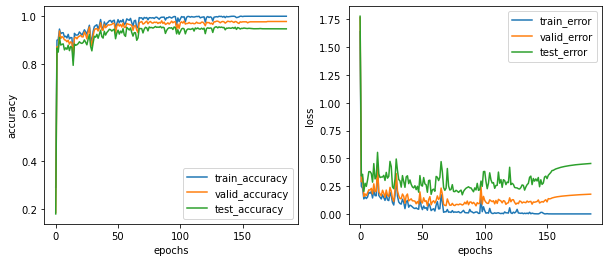

In [112]:
m10.plots()

# 11 model with learning_rate=0.001, h1_neurons=300, h2_neurons=200, alpha_momentum=0.9, batch_size=1(online learning)

In [21]:
m11 = NeuralNetwork(input_neurons=X_train.shape[1], h1_neurons=300, h2_neurons=200, output_neurons=6, learning_rate=0.001)
m11.train_early_stopping(X_train, y_train, X_valid, y_valid, batch_size=1, alpha_momentum=0.9)
m11_stats = m11.post_training_evaluation(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [95]:
display([missclassfied_patterns(m11, X_train, y_train), missclassfied_patterns(m11, X_valid, y_valid), missclassfied_patterns(m11, X_test, y_test)], ['missclassfied_train', 'missclassfied_valid', 'missclassfied_test'])

,y_pred,y_true,0
0,3,4,1
,y_pred,y_true,0
0,4,3,6
1,3,4,5
2,2,0,2
3,1,0,1
4,1,2,1
,y_pred,y_true,0
0,4,3,52
1,0,1,22


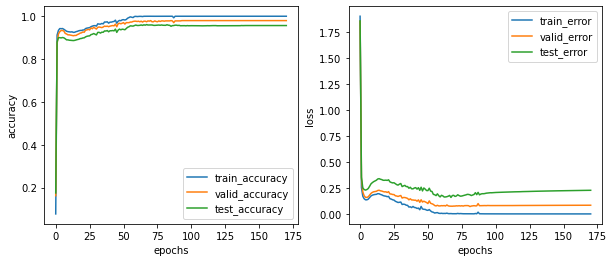

In [113]:
m11.plots()

# 12 model with learning_rate=0.01, h1_neurons=300, h2_neurons=200, alpha_momentum=0.9, batch_size=1(online learning)

In [22]:
m12 = NeuralNetwork(input_neurons=X_train.shape[1], h1_neurons=300, h2_neurons=200, output_neurons=6, learning_rate=0.01)
m12.train_early_stopping(X_train, y_train, X_valid, y_valid, batch_size=1, alpha_momentum=0.9)
m12_stats = m12.post_training_evaluation(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [96]:
display([missclassfied_patterns(m12, X_train, y_train), missclassfied_patterns(m12, X_valid, y_valid), missclassfied_patterns(m12, X_test, y_test)], ['missclassfied_train', 'missclassfied_valid', 'missclassfied_test'])

,y_pred,y_true,0
0,4,3,2
,y_pred,y_true,0
0,4,3,6
1,2,0,2
2,0,1,1
3,1,0,1
4,1,2,1
5,3,4,1
,y_pred,y_true,0
0,4,3,67


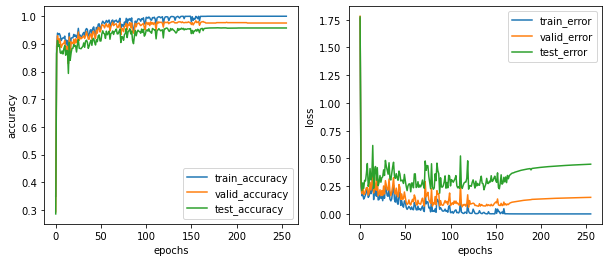

In [114]:
m12.plots()

# 13 model with learning_rate=0.001, h1_neurons=300, h2_neurons=100, alpha_momentum=0.9, batch_size=50

In [23]:
m13 = NeuralNetwork(input_neurons=X_train.shape[1], h1_neurons=300, h2_neurons=100, output_neurons=6, learning_rate=0.001)
m13.train_early_stopping(X_train, y_train, X_valid, y_valid, batch_size=50, alpha_momentum=0.9)
m13_stats = m13.post_training_evaluation(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [97]:
display([missclassfied_patterns(m13, X_train, y_train), missclassfied_patterns(m13, X_valid, y_valid), missclassfied_patterns(m13, X_test, y_test)], ['missclassfied_train', 'missclassfied_valid', 'missclassfied_test'])

,y_pred,y_true,0
0,4,3,14
1,3,4,12
,y_pred,y_true,0
0,4,3,5
1,2,0,3
2,3,4,3
3,1,0,2
4,1,2,1
,y_pred,y_true,0
0,4,3,50


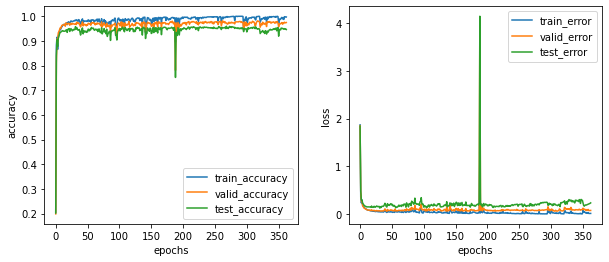

In [115]:
m13.plots()

# 14 model with learning_rate=0.01, h1_neurons=300, h2_neurons=100, alpha_momentum=0.9, batch_size=50

In [24]:
m14 = NeuralNetwork(input_neurons=X_train.shape[1], h1_neurons=300, h2_neurons=100, output_neurons=6, learning_rate=0.01)
m14.train_early_stopping(X_train, y_train, X_valid, y_valid, batch_size=50, alpha_momentum=0.9)
m14_stats = m14.post_training_evaluation(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [98]:
display([missclassfied_patterns(m14, X_train, y_train), missclassfied_patterns(m14, X_valid, y_valid), missclassfied_patterns(m14, X_test, y_test)], ['missclassfied_train', 'missclassfied_valid', 'missclassfied_test'])

,y_pred,y_true,0
0,4,5,1902
1,4,3,1140
2,4,1,380
3,3,2,256
4,1,2,215
5,4,2,209
6,4,0,186
7,3,4,171
8,3,1,84
9,0,5,77


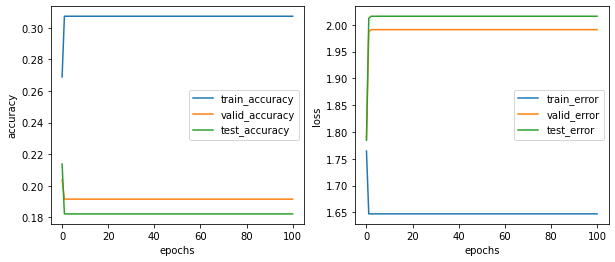

In [116]:
m14.plots()

# 15 model with learning_rate=0.001, h1_neurons=300, h2_neurons=200, alpha_momentum=0.9, batch_size=50

In [25]:
m15 = NeuralNetwork(input_neurons=X_train.shape[1], h1_neurons=300, h2_neurons=200, output_neurons=6, learning_rate=0.001)
m15.train_early_stopping(X_train, y_train, X_valid, y_valid, batch_size=50, alpha_momentum=0.9)
m15_stats = m15.post_training_evaluation(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [99]:
display([missclassfied_patterns(m15, X_train, y_train), missclassfied_patterns(m15, X_valid, y_valid), missclassfied_patterns(m15, X_test, y_test)], ['missclassfied_train', 'missclassfied_valid', 'missclassfied_test'])

,y_pred,y_true,0
0,4,3,20
1,3,4,4
,y_pred,y_true,0
0,4,3,6
1,1,2,2
2,0,1,1
3,1,0,1
4,2,0,1
5,3,4,1
6,5,3,1


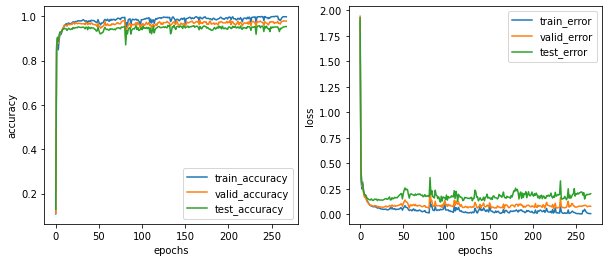

In [117]:
m15.plots()

# 16 model with learning_rate=0.01, h1_neurons=300, h2_neurons=200, alpha_momentum=0.9, batch_size=50

In [26]:
m16 = NeuralNetwork(input_neurons=X_train.shape[1], h1_neurons=300, h2_neurons=200, output_neurons=6, learning_rate=0.01)
m16.train_early_stopping(X_train, y_train, X_valid, y_valid, batch_size=50, alpha_momentum=0.9)
m16_stats = m16.post_training_evaluation(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [100]:
display([missclassfied_patterns(m16, X_train, y_train), missclassfied_patterns(m16, X_valid, y_valid), missclassfied_patterns(m16, X_test, y_test)], ['missclassfied_train', 'missclassfied_valid', 'missclassfied_test'])

,y_pred,y_true,0
0,5,4,1699
1,5,3,1261
2,5,2,801
3,5,1,520
4,5,0,308
5,4,2,1
,y_pred,y_true,0
0,5,4,137
1,5,3,129
2,5,0,123


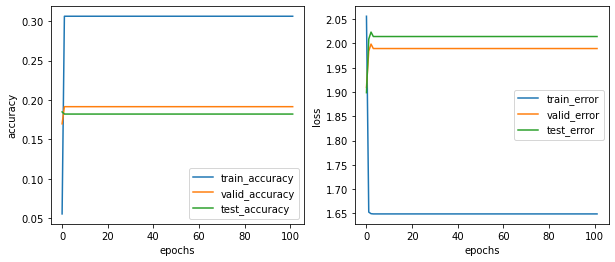

In [118]:
m16.plots()

# Models comparison

In [35]:
results = [
    ["m1", m1_stats['best_model_train_error'], m1_stats['best_model_valid_error'], m1_stats['best_model_test_error'], m1_stats['best_model_train_accuracy'], m1_stats['best_model_valid_accuracy'], m1_stats['best_model_test_accuracy']],
    ["m2", m2_stats['best_model_train_error'], m2_stats['best_model_valid_error'], m2_stats['best_model_test_error'], m2_stats['best_model_train_accuracy'], m2_stats['best_model_valid_accuracy'], m2_stats['best_model_test_accuracy']],
    ["m3", m3_stats['best_model_train_error'], m3_stats['best_model_valid_error'], m3_stats['best_model_test_error'], m3_stats['best_model_train_accuracy'], m3_stats['best_model_valid_accuracy'], m3_stats['best_model_test_accuracy']],
    ["m4", m4_stats['best_model_train_error'], m4_stats['best_model_valid_error'], m4_stats['best_model_test_error'], m4_stats['best_model_train_accuracy'], m4_stats['best_model_valid_accuracy'], m4_stats['best_model_test_accuracy']],
    ["m5", m5_stats['best_model_train_error'], m5_stats['best_model_valid_error'], m5_stats['best_model_test_error'], m5_stats['best_model_train_accuracy'], m5_stats['best_model_valid_accuracy'], m5_stats['best_model_test_accuracy']],
    ["m6", m6_stats['best_model_train_error'], m6_stats['best_model_valid_error'], m6_stats['best_model_test_error'], m6_stats['best_model_train_accuracy'], m6_stats['best_model_valid_accuracy'], m6_stats['best_model_test_accuracy']],
    ["m7", m7_stats['best_model_train_error'], m7_stats['best_model_valid_error'], m7_stats['best_model_test_error'], m7_stats['best_model_train_accuracy'], m7_stats['best_model_valid_accuracy'], m7_stats['best_model_test_accuracy']],
    ["m8", m8_stats['best_model_train_error'], m8_stats['best_model_valid_error'], m8_stats['best_model_test_error'], m8_stats['best_model_train_accuracy'], m8_stats['best_model_valid_accuracy'], m8_stats['best_model_test_accuracy']],
    ["m9", m9_stats['best_model_train_error'], m9_stats['best_model_valid_error'], m9_stats['best_model_test_error'], m9_stats['best_model_train_accuracy'], m9_stats['best_model_valid_accuracy'], m9_stats['best_model_test_accuracy']],
    ["m10", m10_stats['best_model_train_error'], m10_stats['best_model_valid_error'], m10_stats['best_model_test_error'], m10_stats['best_model_train_accuracy'], m10_stats['best_model_valid_accuracy'], m10_stats['best_model_test_accuracy']],
    ["m11", m11_stats['best_model_train_error'], m11_stats['best_model_valid_error'], m11_stats['best_model_test_error'], m11_stats['best_model_train_accuracy'], m11_stats['best_model_valid_accuracy'], m11_stats['best_model_test_accuracy']],
    ["m12", m12_stats['best_model_train_error'], m12_stats['best_model_valid_error'], m12_stats['best_model_test_error'], m12_stats['best_model_train_accuracy'], m12_stats['best_model_valid_accuracy'], m12_stats['best_model_test_accuracy']],
    ["m13", m13_stats['best_model_train_error'], m13_stats['best_model_valid_error'], m13_stats['best_model_test_error'], m13_stats['best_model_train_accuracy'], m13_stats['best_model_valid_accuracy'], m13_stats['best_model_test_accuracy']],
    ["m14", m14_stats['best_model_train_error'], m14_stats['best_model_valid_error'], m14_stats['best_model_test_error'], m14_stats['best_model_train_accuracy'], m14_stats['best_model_valid_accuracy'], m14_stats['best_model_test_accuracy']],
    ["m15", m15_stats['best_model_train_error'], m15_stats['best_model_valid_error'], m15_stats['best_model_test_error'], m15_stats['best_model_train_accuracy'], m15_stats['best_model_valid_accuracy'], m15_stats['best_model_test_accuracy']],
    ["m16", m16_stats['best_model_train_error'], m16_stats['best_model_valid_error'], m16_stats['best_model_test_error'], m16_stats['best_model_train_accuracy'], m16_stats['best_model_valid_accuracy'], m16_stats['best_model_test_accuracy']]    
]

# Creating the DataFrame
pd.DataFrame(results, columns = ['model', 'train_error', 'valid_error', 'test_error', 'train_accuracy', 'valid_accuracy', 'test_accuracy']).sort_values(by='valid_accuracy', ascending=False)

,model,train_error,valid_error,test_error,train_accuracy,valid_accuracy,test_accuracy
6,m7,0.014786,0.047940,0.140899,0.996221,0.987772,0.959620
1,m2,0.015949,0.059914,0.194038,0.993501,0.985054,0.957584
4,m5,0.008610,0.053628,0.161121,0.997279,0.985054,0.953512
3,m4,0.011428,0.065985,0.246659,0.995919,0.983696,0.950119
11,m12,0.001846,0.075340,0.278052,0.999698,0.983696,0.951476
8,m9,0.007333,0.070519,0.192852,0.997733,0.982337,0.957245
14,m15,0.013387,0.054056,0.168197,0.996372,0.982337,0.953512
0,m1,0.001909,0.064495,0.164072,1.000000,0.980978,0.962335
2,m3,0.000809,0.079417,0.208524,1.000000,0.980978,0.956566
9,m10,0.010445,0.090215,0.231441,0.995919,0.980978,0.951815


# Best model with learning_rate=0.001, h1_neurons=300, h2_neurons=200, alpha_momentum=0, batch_size=50, dropout_rate=0.5

In [36]:
best = NeuralNetwork(input_neurons=X_train.shape[1], h1_neurons=300, h2_neurons=200, output_neurons=6, learning_rate=0.001)
best.train_early_stopping(X_train, y_train, X_valid, y_valid, batch_size=50, alpha_momentum=0, dropout_rate=0.5)
best_stats = best.post_training_evaluation(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [101]:
display([missclassfied_patterns(best, X_train, y_train), missclassfied_patterns(best, X_valid, y_valid), missclassfied_patterns(best, X_test, y_test)], ['missclassfied_train', 'missclassfied_valid', 'missclassfied_test'])

,y_pred,y_true,0
0,3,4,5
1,4,3,2
,y_pred,y_true,0
0,4,3,4
1,3,4,2
2,2,0,1
,y_pred,y_true,0
0,4,3,48
1,1,2,17
2,0,1,14


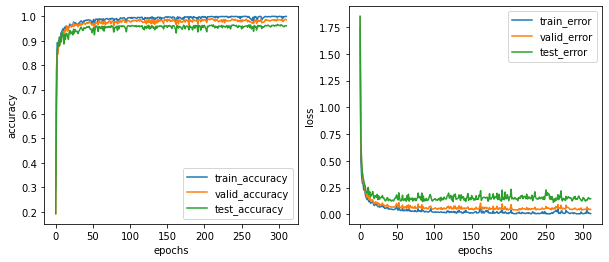

In [102]:
best.plots()

In [39]:
results = [
    ["m1", m1_stats['best_model_train_error'], m1_stats['best_model_valid_error'], m1_stats['best_model_test_error'], m1_stats['best_model_train_accuracy'], m1_stats['best_model_valid_accuracy'], m1_stats['best_model_test_accuracy']],
    ["m2", m2_stats['best_model_train_error'], m2_stats['best_model_valid_error'], m2_stats['best_model_test_error'], m2_stats['best_model_train_accuracy'], m2_stats['best_model_valid_accuracy'], m2_stats['best_model_test_accuracy']],
    ["m3", m3_stats['best_model_train_error'], m3_stats['best_model_valid_error'], m3_stats['best_model_test_error'], m3_stats['best_model_train_accuracy'], m3_stats['best_model_valid_accuracy'], m3_stats['best_model_test_accuracy']],
    ["m4", m4_stats['best_model_train_error'], m4_stats['best_model_valid_error'], m4_stats['best_model_test_error'], m4_stats['best_model_train_accuracy'], m4_stats['best_model_valid_accuracy'], m4_stats['best_model_test_accuracy']],
    ["m5", m5_stats['best_model_train_error'], m5_stats['best_model_valid_error'], m5_stats['best_model_test_error'], m5_stats['best_model_train_accuracy'], m5_stats['best_model_valid_accuracy'], m5_stats['best_model_test_accuracy']],
    ["m6", m6_stats['best_model_train_error'], m6_stats['best_model_valid_error'], m6_stats['best_model_test_error'], m6_stats['best_model_train_accuracy'], m6_stats['best_model_valid_accuracy'], m6_stats['best_model_test_accuracy']],
    ["m7", m7_stats['best_model_train_error'], m7_stats['best_model_valid_error'], m7_stats['best_model_test_error'], m7_stats['best_model_train_accuracy'], m7_stats['best_model_valid_accuracy'], m7_stats['best_model_test_accuracy']],
    ["m8", m8_stats['best_model_train_error'], m8_stats['best_model_valid_error'], m8_stats['best_model_test_error'], m8_stats['best_model_train_accuracy'], m8_stats['best_model_valid_accuracy'], m8_stats['best_model_test_accuracy']],
    ["m9", m9_stats['best_model_train_error'], m9_stats['best_model_valid_error'], m9_stats['best_model_test_error'], m9_stats['best_model_train_accuracy'], m9_stats['best_model_valid_accuracy'], m9_stats['best_model_test_accuracy']],
    ["m10", m10_stats['best_model_train_error'], m10_stats['best_model_valid_error'], m10_stats['best_model_test_error'], m10_stats['best_model_train_accuracy'], m10_stats['best_model_valid_accuracy'], m10_stats['best_model_test_accuracy']],
    ["m11", m11_stats['best_model_train_error'], m11_stats['best_model_valid_error'], m11_stats['best_model_test_error'], m11_stats['best_model_train_accuracy'], m11_stats['best_model_valid_accuracy'], m11_stats['best_model_test_accuracy']],
    ["m12", m12_stats['best_model_train_error'], m12_stats['best_model_valid_error'], m12_stats['best_model_test_error'], m12_stats['best_model_train_accuracy'], m12_stats['best_model_valid_accuracy'], m12_stats['best_model_test_accuracy']],
    ["m13", m13_stats['best_model_train_error'], m13_stats['best_model_valid_error'], m13_stats['best_model_test_error'], m13_stats['best_model_train_accuracy'], m13_stats['best_model_valid_accuracy'], m13_stats['best_model_test_accuracy']],
    ["m14", m14_stats['best_model_train_error'], m14_stats['best_model_valid_error'], m14_stats['best_model_test_error'], m14_stats['best_model_train_accuracy'], m14_stats['best_model_valid_accuracy'], m14_stats['best_model_test_accuracy']],
    ["m15", m15_stats['best_model_train_error'], m15_stats['best_model_valid_error'], m15_stats['best_model_test_error'], m15_stats['best_model_train_accuracy'], m15_stats['best_model_valid_accuracy'], m15_stats['best_model_test_accuracy']],
    ["m16", m16_stats['best_model_train_error'], m16_stats['best_model_valid_error'], m16_stats['best_model_test_error'], m16_stats['best_model_train_accuracy'], m16_stats['best_model_valid_accuracy'], m16_stats['best_model_test_accuracy']],
    ["best", best_stats['best_model_train_error'], best_stats['best_model_valid_error'], best_stats['best_model_test_error'], best_stats['best_model_train_accuracy'], best_stats['best_model_valid_accuracy'], best_stats['best_model_test_accuracy']]
]

# Creating the DataFrame
pd.DataFrame(results, columns = ['model', 'train_error', 'valid_error', 'test_error', 'train_accuracy', 'valid_accuracy', 'test_accuracy']).sort_values(by='valid_accuracy', ascending=False)

,model,train_error,valid_error,test_error,train_accuracy,valid_accuracy,test_accuracy
16,best,0.005045,0.040213,0.142212,0.998942,0.990489,0.964031
6,m7,0.014786,0.047940,0.140899,0.996221,0.987772,0.959620
1,m2,0.015949,0.059914,0.194038,0.993501,0.985054,0.957584
4,m5,0.008610,0.053628,0.161121,0.997279,0.985054,0.953512
3,m4,0.011428,0.065985,0.246659,0.995919,0.983696,0.950119
11,m12,0.001846,0.075340,0.278052,0.999698,0.983696,0.951476
14,m15,0.013387,0.054056,0.168197,0.996372,0.982337,0.953512
8,m9,0.007333,0.070519,0.192852,0.997733,0.982337,0.957245
9,m10,0.010445,0.090215,0.231441,0.995919,0.980978,0.951815
12,m13,0.015580,0.076782,0.173252,0.996070,0.980978,0.953512
